# Example anatomical plot in sagittal view

In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import median_filter

def load_anatomy_tif(tif_path):
    im = Image.open(tif_path)
    h, w = np.shape(im)
    n_frames = im.n_frames
    im_array = np.zeros((h,w,n_frames)) # (400, 570, 660), (DV, ML, AP)
    for i in range(im.n_frames):
        im.seek(i)
        im_array[:,:,i] = np.array(im)
    return im_array

def get_2D_grid_averages_with_count(best_times, ccf_coords, voxel_size = 300, projection_axis = 0):
    # Project ccf_coords onto the 2D plane
    coords_2d = np.delete(ccf_coords, projection_axis, axis=1)
    
    # Calculate the voxel indices for each point
    voxel_indices = np.floor(coords_2d / voxel_size).astype(int)
    
    # Find the bounds for the grid
    min_indices = np.min(voxel_indices, axis=0)
    max_indices = np.max(voxel_indices, axis=0)
    grid_shape = max_indices - min_indices + 1
    
    # Initialize a grid to store the sum and count of best_times for averaging
    sum_grid = np.zeros(grid_shape)
    count_grid = np.zeros(grid_shape)
    
    # Populate the grids with summed times and counts
    for index, time in zip(voxel_indices, best_times):
        normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
        sum_grid[normalized_index] += time
        count_grid[normalized_index] += 1
    
    # Calculate the average best time for each voxel
    with np.errstate(invalid='ignore'):  # Ignore divisions by 0
        avg_grid = np.divide(sum_grid, count_grid)
        avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0
    
    return avg_grid, min_indices, max_indices, count_grid

def get_2D_count_fractions(best_times, ccf_coords, subset_inds, voxel_size = 300, projection_axis = 0):
    # Project ccf_coords onto the 2D plane
    _, min_inds_denom, max_inds_denom, count_grid_denom = get_2D_grid_averages_with_count(best_times, ccf_coords, voxel_size, projection_axis)
    _, min_inds_num, max_inds_num, count_grid_num = get_2D_grid_averages_with_count(best_times[subset_inds], ccf_coords[subset_inds], voxel_size, projection_axis)

    # Calculate the fraction of counts for each voxel
    denom_start = [min_inds_num[0]-min_inds_denom[0],min_inds_num[1]-min_inds_denom[1]]
    num_length = [max_inds_num[0]-min_inds_num[0]+1,max_inds_num[1]-min_inds_num[1]+1]
    with np.errstate(invalid='ignore'):  # Ignore divisions by 0
        fraction_grid = np.divide(count_grid_num, 
                                  count_grid_denom[denom_start[0]:denom_start[0] + num_length[0],denom_start[1]:denom_start[1]+num_length[1]])
        fraction_grid[np.isnan(fraction_grid)] = 0  # Replace NaNs with 0

    return fraction_grid, min_inds_num, max_inds_num

def plot_2d_heatmap(ax, data_array, ccf_coords, 
                               vlims = [0, 50], voxel_size = 300, projection_axis = 0, 
                               type = 'count', subset_inds = None, 
                               cmap = 'Greys', 
                               filter_size = 3,
                               alpha = 0.9,
                               xlims = None, ylims = None, 
                               xticks = [], yticks = [],
                               xtitle = None, ytitle = None,
                               title = None,
                               transpose = False):
    avg_grid, min_inds, max_inds, count_grid = get_2D_grid_averages_with_count(data_array, ccf_coords, voxel_size, projection_axis)
    if type == 'count':
        data = count_grid
    elif type == 'average':
        data = avg_grid
    elif type == 'fraction':
        data, min_inds, max_inds = get_2D_count_fractions(data_array, ccf_coords, subset_inds, voxel_size, projection_axis)
    filtered_data = median_filter(data, size = filter_size)
    masked_data = np.ma.masked_where(data == 0, filtered_data)
    data_to_plot = masked_data.T if transpose else masked_data
    extent = [min_inds[1]*voxel_size, (max_inds[1]+1)*voxel_size, min_inds[0]*voxel_size, (max_inds[0]+1)*voxel_size]
    if transpose:
        extent = [min_inds[0]*voxel_size, (max_inds[0]+1)*voxel_size, min_inds[1]*voxel_size, (max_inds[1]+1)*voxel_size]
    im = ax.imshow(data_to_plot, cmap = cmap, origin = 'lower', 
                   vmin = vlims[0], vmax = vlims[1], aspect='equal', 
                   extent= extent, 
                   alpha = alpha)
    if xlims is not None:
        ax.set_xlim(xlims)
    if ylims is not None:
        ax.set_ylim(ylims)
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
    if xtitle is not None:
        ax.set_xlabel(xtitle)
    if ytitle is not None:
        ax.set_ylabel(ytitle)

    if title is not None:
        ax.set_title(title)
    return im

def plot_anatomy_slice(ax, anatomy_image,
                           dv_slice, ml_slice, ap_slice,
                           extent,
                           cmap = 'Greys_r',
                           alpha = 0.9,
                           transpose = False):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    
    data_to_plot = anatomy_image[dv_slice,ml_slice,ap_slice]
    if transpose:
        data_to_plot = data_to_plot.T
    
    ax.imshow(data_to_plot,
                extent = extent,
                cmap = cmap,
                alpha = alpha)
    return ax

In [2]:
def plot_sagittal_heatmap(anatomy_image, ccf_coords, data_to_plot,fig = None, ax = None, 
                          plot_size_line = True,
                          filter_size = 1, voxel_size = 300, image_res = 20,
                          dv_lims = [0,8000], ml_slice = 5000, ap_lims = [1500,13500],
                          cbar_lims = [0,0.3]):
                          
        '''
        Plot a sagittal heatmap of the data_to_plot with anatomical background.

        Parameters
        ----------
        anatomy_image : np.array
            3D array of the anatomical image.
        ccf_coords : np.array
            3D array of the ccf coordinates.
        data_to_plot : np.array
            1D array of the data to plot.
        fig : matplotlib.figure.Figure, optional
            Figure to plot the heatmap on. The default is None.
        ax : matplotlib.axes.Axes, optional
            Axes to plot the heatmap on. The default is None.
        plot_size_line : bool, optional
            Whether to plot a scale bar. The default is True.
        filter_size : int, optional
            Size of the median filter. The default is 1 (
            which corresponds to no filtering).
        voxel_size : int, optional
            Size of the voxels in micrometers. The default is 300.
        image_res : int, optional
            Resolution of the anatomy image. The default is 20.
        dv_lims : list, optional
            Limits of the dorsal-ventral axis. The default is [0,8000].
        ml_slice : int, optional
            Slice of the medial-lateral axis. The default is 5000.
        ap_lims : list, optional
            Limits of the anterior-posterior axis. The default is [1500,13500].
        cbar_lims : list, optional
            Limits of the colorbar. The default is [0,0.3].
    
        Returns
        -------
        None.
        '''
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize = (6,6))

        

        plot_anatomy_slice(ax, anatomy_image,
                                dv_slice = slice(dv_lims[0]//image_res,dv_lims[1]//image_res), 
                                ml_slice = ml_slice//image_res,
                                ap_slice = slice(ap_lims[0]//image_res,ap_lims[1]//image_res),
                                extent = [ap_lims[0],ap_lims[1],dv_lims[1],dv_lims[0]])

        

        im = plot_2d_heatmap(ax, data_to_plot, ccf_coords,
                                        vlims = cbar_lims, projection_axis = 0,
                                        voxel_size= voxel_size, filter_size = filter_size,
                                        type = 'average',
                                        cmap = 'viridis',
                                        xlims = ap_lims, ylims = [dv_lims[1],dv_lims[0]],
                                        title = '',
                                        transpose = False)
        
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad = 0.02, fraction = 0.02)
        
        ax.set_xlabel('Anterior-Posterior')
        ax.set_ylabel('Dorsal-Ventral')

        
        if plot_size_line: ax.plot([2500,3000],[7800,7800], '-', color = 'white')

In [3]:
image_file = '../data/AllenRefVolCoronal_10_ds222.tif'

image_array = load_anatomy_tif(image_file)

In [4]:
example_dict = pickle.load(open('../data/example_anatomy_plot_data.pkl', 'rb'))
r2 = example_dict['r2']
ccf_coords = example_dict['ccf_coords']

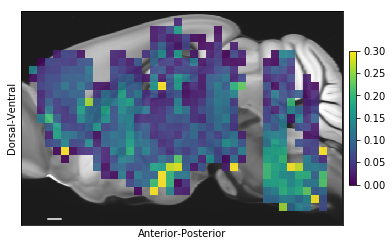

In [5]:
plot_sagittal_heatmap(image_array, ccf_coords, r2)